In [1]:
import itertools
import json

import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 20)

In [2]:
with open("../data/benchmark_laptop.json") as f:
    run = json.load(f)

In [3]:
results = []
for b in run["benchmarks"]:
    name, random_seed_str, site_count_str = b["name"].split("/")
    name = "_".join(name.split("_")[:-1])
    seed = int(random_seed_str)
    site_count = int(site_count_str)
    real_time = float(b["real_time"])
    results.append((name, site_count, seed, real_time))

In [4]:
data = pd.DataFrame(results, columns=["algo", "site_count", "seed", "ms"])
data.sample(n=20)

,algo,site_count,seed,ms
289,ping_pong,5,104,0.256310
270,ping_pong,4,100,0.268019
54,boost,4,109,6.101252
174,boost,12,109,2281.848837
72,boost,5,112,6.940616
189,boost,13,109,1207.853364
92,boost,7,102,106.348027
416,ping_pong,13,111,215.674684
419,ping_pong,13,114,261.190856
307,ping_pong,6,107,0.610182


In [5]:
data.groupby("algo").ms.mean()

algo
boost        1121.05925
ping_pong     104.15581
Name: ms, dtype: float64

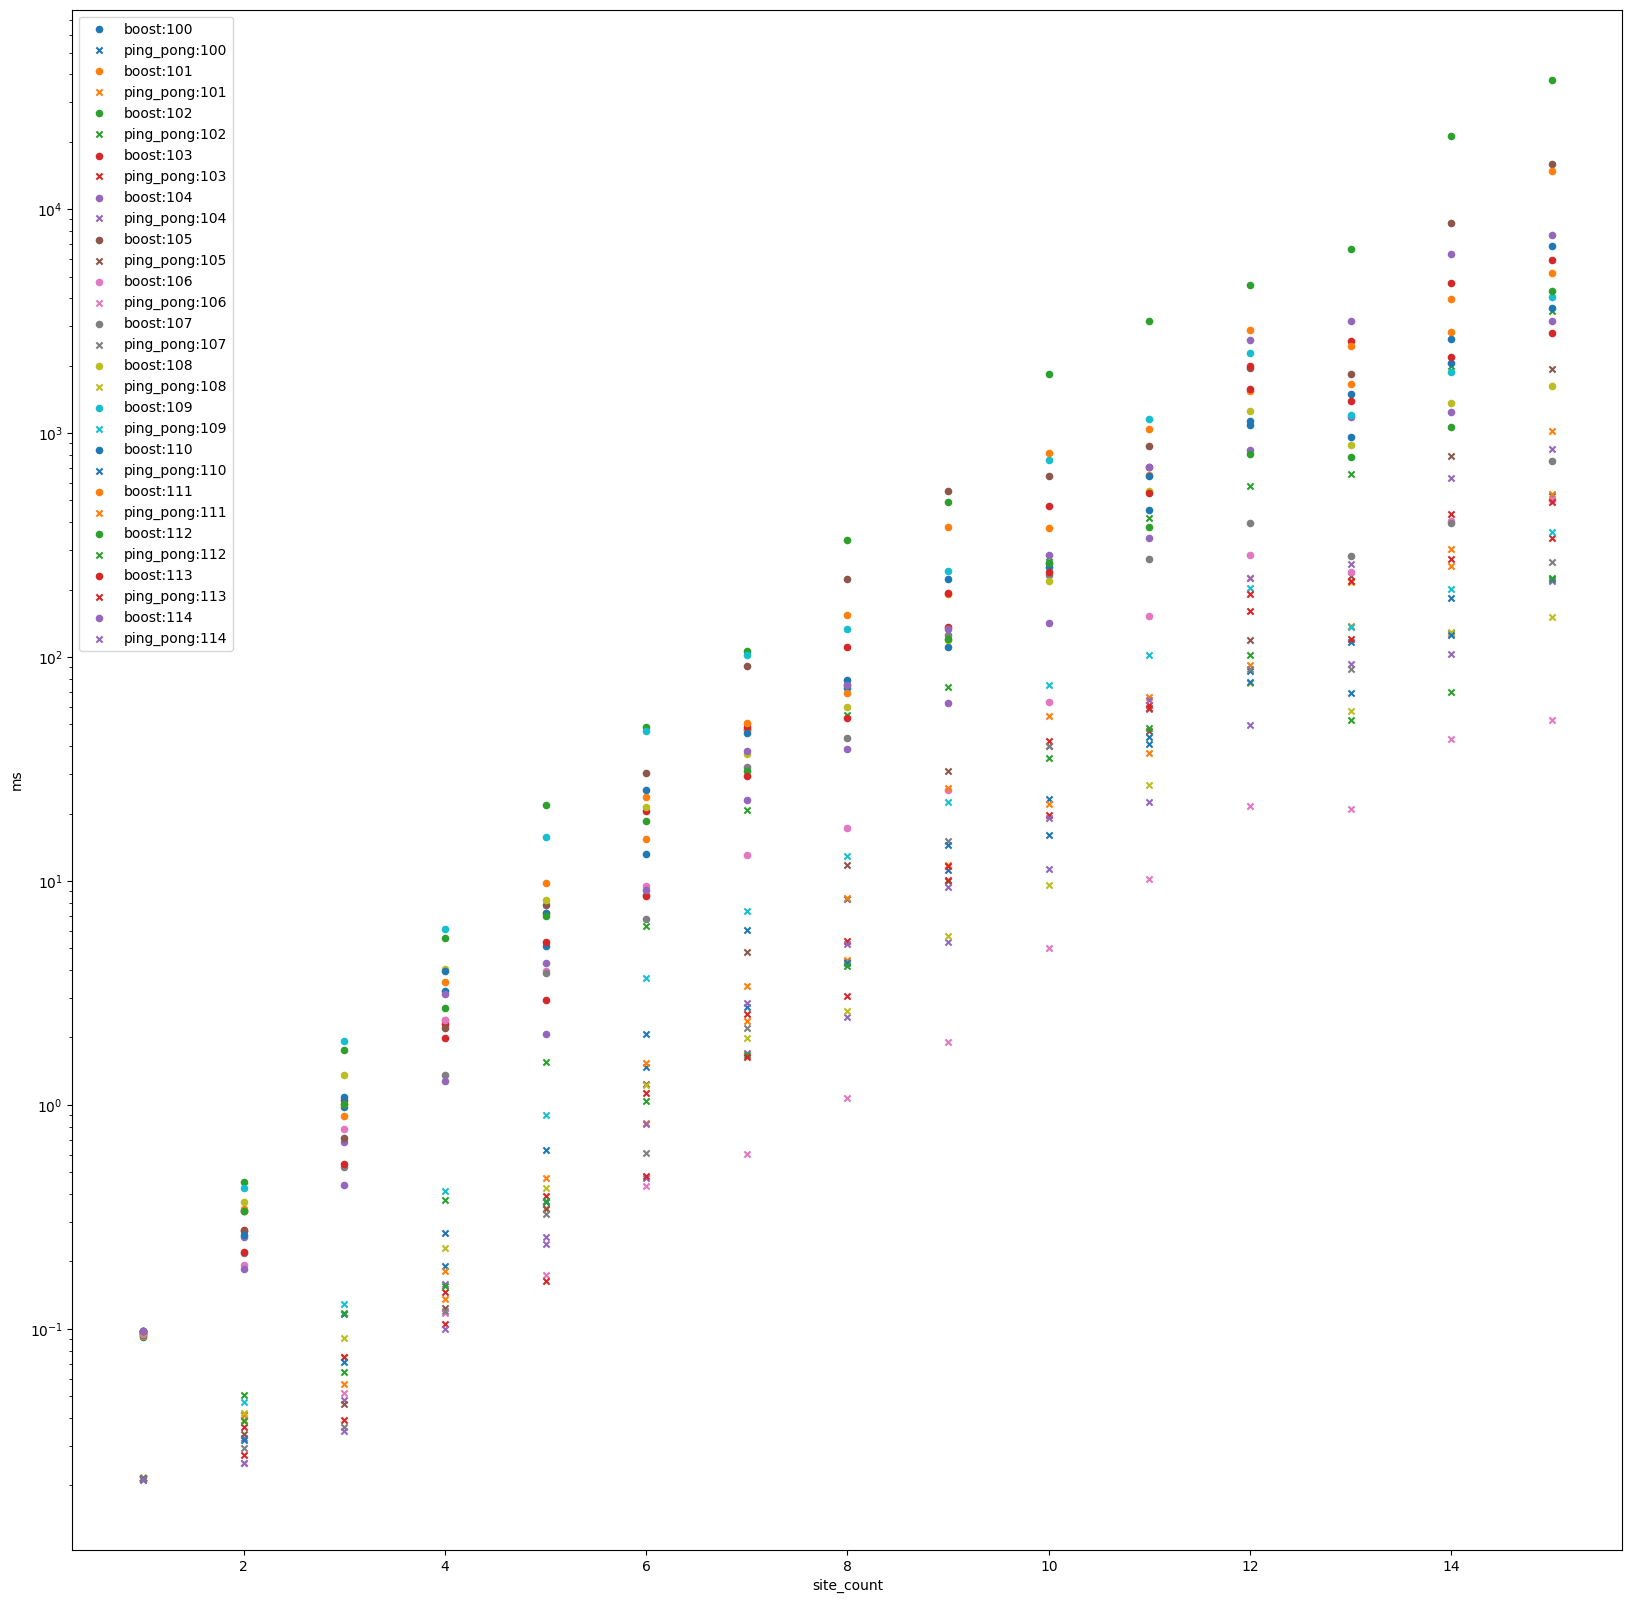

In [6]:
colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
markers = ["o", "x", "s", "d", "^", "v", "<", ">", "P", "*"]
algo2marker = {algo: marker for algo, marker in zip(data["algo"].unique(), markers)}

fig, ax = plt.subplots()

for seed, group in data.groupby("seed"):
    color = next(colors)
    for algo, g in group.groupby("algo"):
        ax = g.plot(
            y="ms",
            x="site_count",
            kind="scatter",
            color=color,
            marker=algo2marker[algo],
            ax=ax,
            label=f"{algo}:{seed}",
            logy=True,
        )

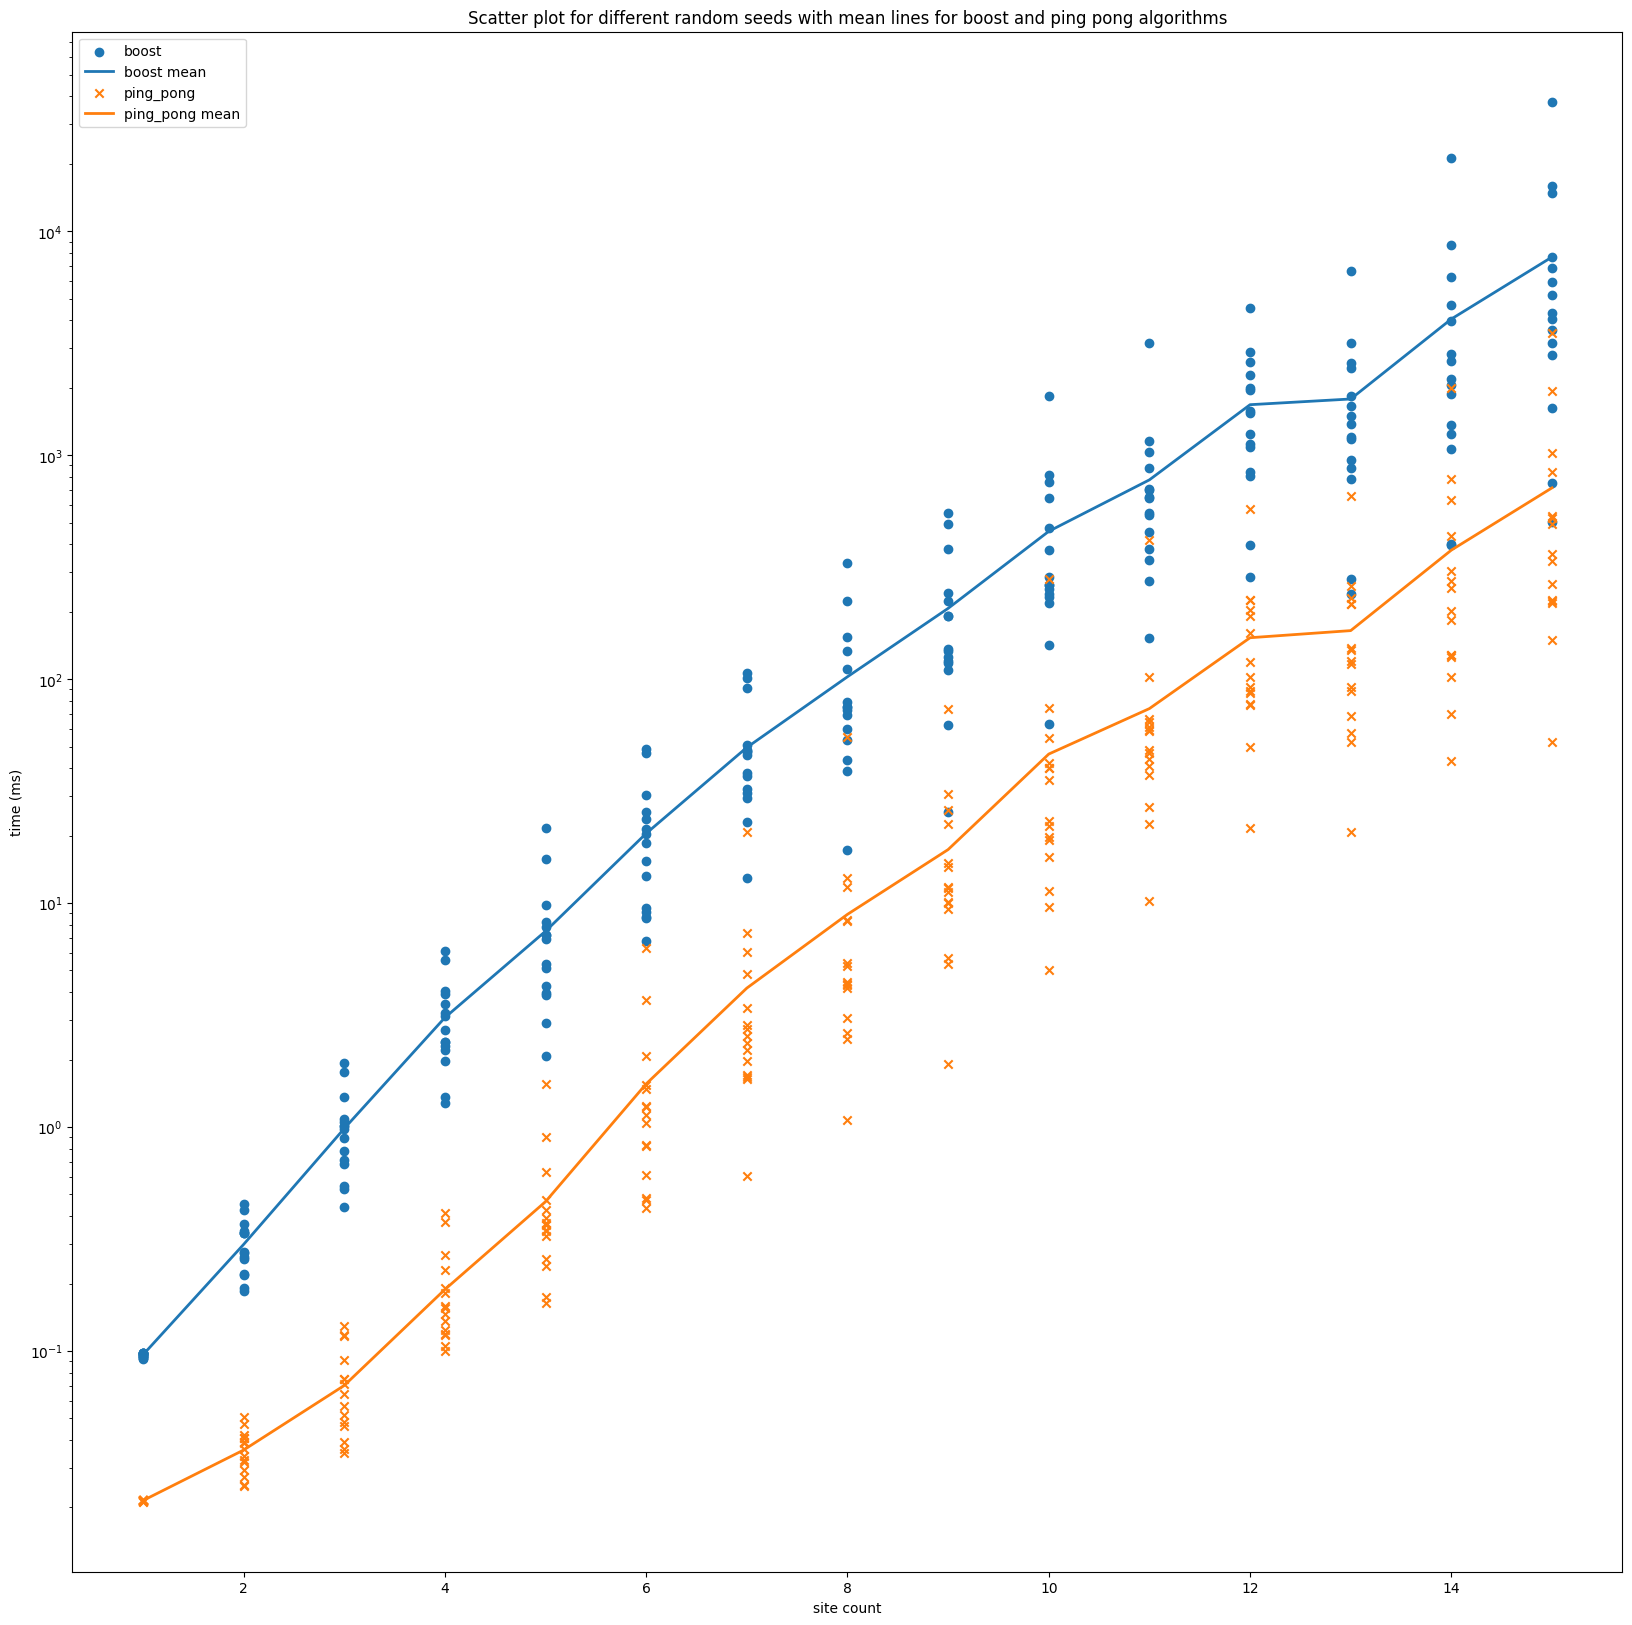

In [7]:
colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
markers = ["o", "x", "s", "d", "^", "v", "<", ">", "P", "*"]
algo2marker = {algo: marker for algo, marker in zip(data["algo"].unique(), markers)}
fig, ax = plt.subplots()

for algo, group in data.groupby("algo"):
    color = next(colors)
    for i, (seed, g) in enumerate(group.groupby("seed")):
        ax.scatter(
            g["site_count"],
            g["ms"],
            color=color,
            marker=algo2marker[algo],
            label=algo if i == 0 else None,  # only label once
        )

    mean_vals = group.groupby("site_count")["ms"].mean()
    ax.plot(
        mean_vals.index,
        mean_vals.values,
        color=color,
        linestyle="-",
        linewidth=2,
        label=f"{algo} mean",
    )

ax.set_xlabel("site count")
ax.set_yscale("log")
ax.set_ylabel("time (ms)")
ax.set_title(
    "Scatter plot for different random seeds with mean lines for boost and ping pong algorithms"
)
ax.legend()

In [8]:
pivoted = (
    data[data.algo.isin(["boost", "ping_pong"])]
    .pivot_table(index=["seed", "site_count"], columns="algo", values="ms")
    .reset_index()
)
pivoted["rel_diff"] = pivoted["boost"] / pivoted["ping_pong"]

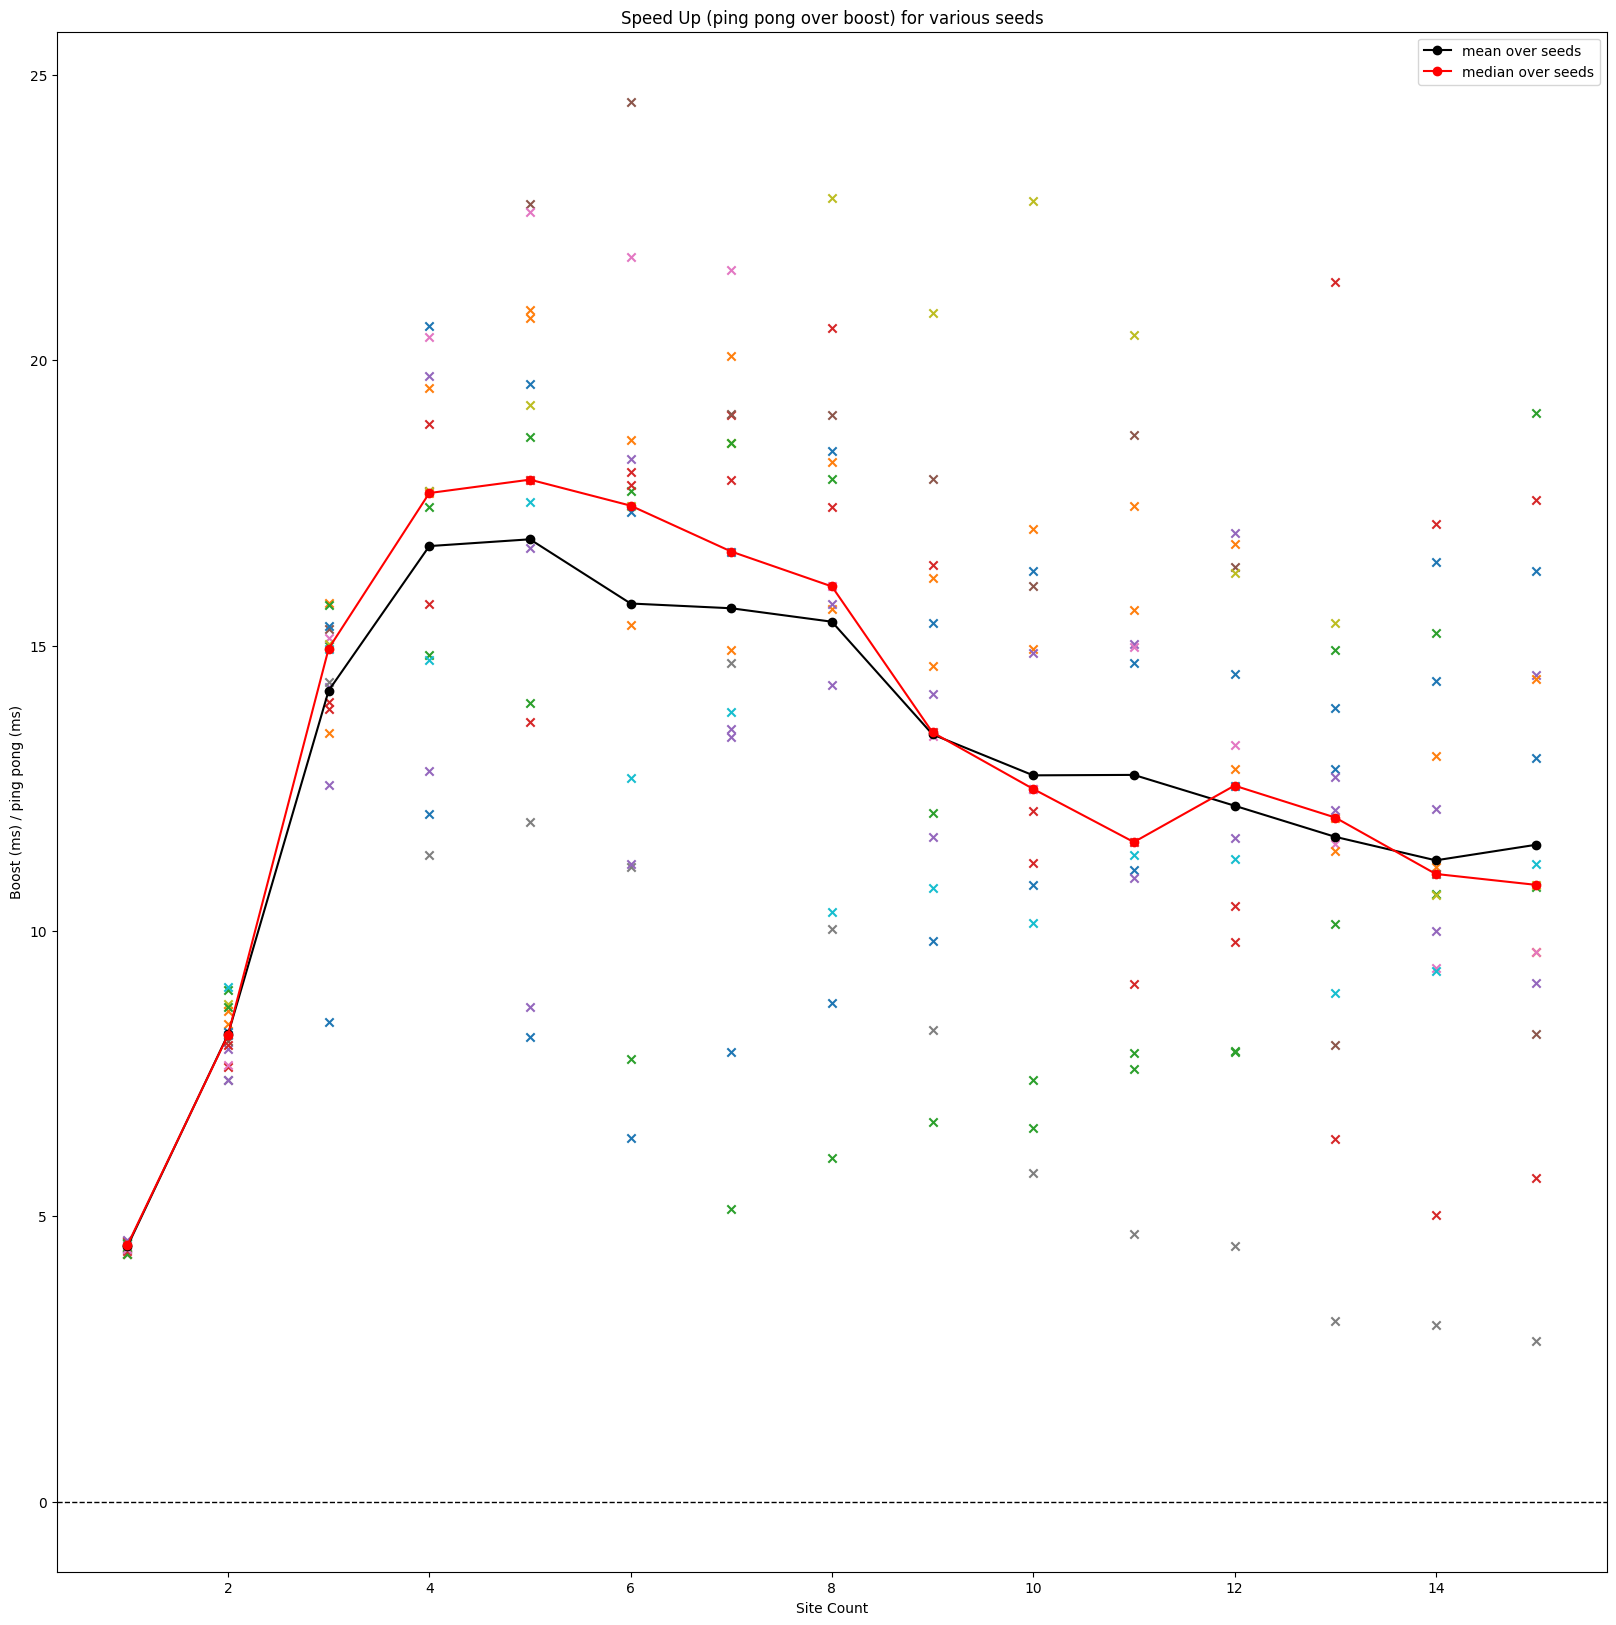

In [9]:
fig, ax = plt.subplots()
colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

for seed, group in pivoted.groupby("seed"):
    color = next(colors)
    ax.scatter(
        group["site_count"],
        group["rel_diff"],
        marker="x",
        # label=f"seed {seed}",
        color=color,
    )

rel_diff_described = pivoted.groupby("site_count").rel_diff.describe().reset_index()
ax.plot(
    rel_diff_described["site_count"],
    rel_diff_described["mean"],
    marker="o",
    linestyle="-",
    label="mean over seeds",
    color="black",
)
ax.plot(
    rel_diff_described["site_count"],
    rel_diff_described["50%"],
    marker="o",
    linestyle="-",
    label="median over seeds",
    color="red",
)

ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_title("Speed Up (ping pong over boost) for various seeds")
ax.set_xlabel("Site Count")
ax.set_ylabel("Boost (ms) / ping pong (ms)")
ax.legend()